In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
use_cuda=True
from sklearn.model_selection import train_test_split
torch.manual_seed(2)
np.random.seed(2)

In [0]:
# orig_train=np.load("/content/drive/My Drive/CelebA/image_array_20000.npy")
real_train=np.load("/content/drive/My Drive/CelebA/image_array_10000.npy")
fake_train=np.load("/content/drive/My Drive/CelebA/image_fake_array_10000.npy")


In [0]:
array_real = np.transpose(real_train, (0, 1, 3, 2))
array_real = np.transpose(array_real, (0, 2, 1, 3))
array_fake = np.transpose(fake_train, (0, 1, 3, 2))
array_fake = np.transpose(array_fake, (0, 2, 1, 3))

In [0]:
array_real=real_train
array_fake=fake_train

In [0]:
train_x=np.concatenate([array_real, array_fake])
train_y=np.concatenate([np.zeros(len(array_real)), np.ones(len(array_fake))])

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, stratify=train_y, test_size=0.2, shuffle=True)



In [0]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision
import torchvision.transforms as transforms


class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),  transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

transform1 = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

dataset = MyDataset(train_x, train_y, transform=transform)
dataloader = DataLoader(dataset, 50, shuffle=True)

In [0]:
def train(model ,optimiser, criterion, num_epochs, flag=0):
  tr_acc=[]
  val_acc=[]
  loss_dat=[]
  start=0
  
  if flag:
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start = checkpoint['epoch']
    loss = checkpoint['loss']
    model.train()

  for epoch in range(start, num_epochs):

    for local_X, local_Y in dataloader:
      local_X, local_Y= local_X.cuda(), local_Y.cuda()
      optimizer.zero_grad()

      outputs=model(local_X)
      loss=criterion(outputs, local_Y)
      loss.backward()

      optimizer.step()
    
    # scheduler.step()
    a=model_accuracy(model, x_train, y_train, 50)
    b=model_accuracy(model, x_test, y_test, 50)
    
    tr_acc.append(a)
    val_acc.append(b)
    loss_dat.append(loss.item())

    if epoch%10==0:
      print("Epoch:", epoch, loss.item(), "Train Acc:", a, "Val Acc:", b)
    
    # if epoch%50==0:
    #   torch.save({'epoch': epoch,
    #               'model_state_dict': model.state_dict(),
    #               'optimizer_state_dict': optimizer.state_dict(),
    #               'loss': loss,}, "/content/drive/My Drive/DL_CIFAR_"+str(model)[:11]+"_"+str(epoch))
  return tr_acc, val_acc, loss_dat

def model_accuracy(model, data_x, data_y, batch_size):

  correct = 0
  total = 0

  dataset_dev = MyDataset(data_x, data_y, transform=transform1)
  dataloader_dev = DataLoader(dataset_dev, 50, shuffle=False)
  with torch.no_grad():
      for local_X, local_Y in dataloader_dev:
          local_X, local_Y= local_X.cuda(), local_Y.cuda()
          outputs = model(local_X)
          _, predicted = torch.max(outputs.data, 1)
          total += local_Y.size(0)
          correct += (predicted == local_Y).sum().item()

  return 100 * correct / total

In [0]:
class CNN_Model_2(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1= torch.nn.Conv2d(3, 16, 7)
    self.conv2= torch.nn.Conv2d(16, 16, 3)
    self.pool= torch.nn.MaxPool2d(2,2)
    self.drop= torch.nn.Dropout(p=0.25)
    self.conv_batchnorm=torch.nn.BatchNorm2d(16)
    self.linear1=nn.Linear(11664, 2)
    

  def forward(self, x):
    x=self.pool(F.relu(self.conv_batchnorm(self.conv1(x))))
    x=F.relu(self.conv_batchnorm(self.conv2(x)))
    x=x.view(-1, 11664)

    
    x=self.drop(x)
    x=(self.linear1(x))

    return x

In [0]:
net_2=CNN_Model_2()
net_2.cuda()

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adagrad(net_2.parameters(), lr=0.1, weight_decay=0.0005) #regularisation l2 (Weight decay and L2 regularisation is same for SGD)
flag=0
num_epochs=50
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

tr_acc, val_acc, loss_dat=train(net_2, optimizer, criterion, num_epochs, 0)


Epoch: 0 0.26525622606277466 Train Acc: 98.35 Val Acc: 98.475
Epoch: 10 0.0002584743488114327 Train Acc: 99.625 Val Acc: 99.575
Epoch: 20 2.0432471501408145e-05 Train Acc: 99.83125 Val Acc: 99.725
Epoch: 30 0.00012461184815037996 Train Acc: 99.825 Val Acc: 99.8
Epoch: 40 0.00046193599700927734 Train Acc: 99.95625 Val Acc: 99.95


In [0]:
num_epochs=50
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

tr_acc, val_acc, loss_dat=train(net_2, optimizer, criterion, num_epochs, 0)


Epoch: 0 0.10290184617042542 Train Acc: 93.05625 Val Acc: 92.35
Epoch: 10 0.18279582262039185 Train Acc: 93.96875 Val Acc: 93.325
Epoch: 20 0.11211235076189041 Train Acc: 93.93125 Val Acc: 93.75
Epoch: 30 0.21873708069324493 Train Acc: 94.075 Val Acc: 93.2
Epoch: 40 0.1460111290216446 Train Acc: 94.71875 Val Acc: 94.375


In [0]:


dataset_test = MyDataset(test_x, np.zeros((test_x.shape[0],)), transform=transform1)
dataloader_test = DataLoader(dataset_test, 50, shuffle=False)
preds=[]

for local_X, local_Y in dataloader_test:
  local_X= local_X.cuda()
  outputs=net_3(local_X)
  preds.extend(((outputs.max(1)[1]).data).cpu().numpy())

from typing import List
def write_prediction(prediction: List[int], filename: str):
    with open(filename, 'w') as fp:
        print('Id,Category', file=fp)
        for i, pred in enumerate(prediction):
            print(f'{i},{pred}', file=fp)

write_prediction(preds, "test_Model2.txt")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import copy
chart1_train=copy.deepcopy(tr_acc)
chart1_val=copy.deepcopy(val_acc)
chart1_loss=copy.deepcopy(loss_dat)

In [0]:
chart2_train

[9.977777777777778,
 11.593333333333334,
 11.753333333333334,
 14.775555555555556,
 15.775555555555556,
 14.38888888888889,
 15.544444444444444,
 13.677777777777777,
 15.046666666666667,
 16.57111111111111,
 17.375555555555554,
 18.42,
 16.642222222222223,
 17.59777777777778,
 17.40888888888889,
 17.473333333333333,
 17.44,
 19.286666666666665,
 18.26222222222222,
 18.19333333333333,
 17.302222222222223,
 17.61111111111111,
 16.977777777777778,
 18.573333333333334,
 17.108888888888888,
 16.864444444444445,
 18.64666666666667,
 18.68888888888889,
 16.46,
 19.64,
 31.884444444444444,
 34.25111111111111,
 34.76,
 36.24,
 37.27333333333333,
 36.58222222222222,
 36.86888888888889,
 38.07333333333333,
 38.48222222222222,
 38.6,
 38.79333333333334,
 38.99777777777778,
 38.82888888888889,
 40.51111111111111,
 40.42888888888889,
 40.62,
 40.964444444444446,
 40.28888888888889,
 40.102222222222224,
 40.39333333333333,
 40.75555555555555,
 41.47555555555556,
 42.08222222222222,
 41.32888888888889

In [0]:
chart2_val

[9.5,
 11.98,
 11.36,
 14.28,
 15.72,
 13.34,
 14.38,
 12.86,
 14.36,
 16.58,
 16.16,
 17.72,
 15.98,
 16.56,
 16.98,
 16.92,
 17.38,
 18.48,
 17.44,
 17.52,
 15.54,
 17.04,
 15.92,
 17.64,
 16.12,
 16.38,
 17.56,
 18.02,
 15.94,
 18.28,
 30.46,
 31.36,
 31.8,
 33.5,
 34.02,
 33.54,
 33.42,
 34.04,
 34.5,
 34.76,
 34.78,
 33.38,
 34.06,
 35.36,
 35.68,
 35.14,
 34.92,
 35.06,
 34.74,
 34.78,
 34.06,
 35.72,
 35.64,
 34.42,
 35.22,
 35.98,
 35.96,
 35.82,
 36.14,
 36.42,
 40.9,
 40.94,
 40.7,
 40.72,
 40.9,
 40.78,
 40.98,
 40.86,
 41.14,
 41.16,
 41.16,
 41.12,
 41.06,
 40.86,
 40.9,
 41.28,
 41.2,
 41.1,
 41.5,
 41.4,
 41.84,
 40.82,
 42.14,
 41.94,
 41.18,
 41.6,
 41.32,
 41.68,
 41.56,
 41.26,
 41.7,
 41.68,
 41.56,
 42.08,
 41.96,
 42.08,
 42.28,
 41.96,
 41.94,
 41.74,
 42.26,
 42.0,
 42.16,
 42.08,
 42.16,
 42.12,
 42.08,
 42.18,
 42.08,
 42.24,
 42.3,
 42.02,
 42.24,
 42.0,
 41.92,
 42.4,
 41.96,
 42.02,
 42.02,
 42.34,
 42.12,
 42.16,
 42.14,
 42.08,
 42.06,
 42.08,
 42.08,
 42

In [0]:
chart2_loss

[4.061212062835693,
 3.9027771949768066,
 3.851879358291626,
 3.5296099185943604,
 3.8565194606781006,
 3.4226269721984863,
 3.4289257526397705,
 3.9483706951141357,
 3.6368257999420166,
 3.491438627243042,
 3.5113394260406494,
 3.324786901473999,
 3.5452258586883545,
 3.26455020904541,
 3.361757516860962,
 3.9537103176116943,
 3.3016862869262695,
 3.1986048221588135,
 3.727839708328247,
 3.807781934738159,
 3.9263720512390137,
 3.7467498779296875,
 3.603242874145508,
 3.343951940536499,
 3.269167184829712,
 3.330883502960205,
 4.0336527824401855,
 3.579582929611206,
 2.9710114002227783,
 3.3857293128967285,
 2.4178993701934814,
 2.629577875137329,
 2.556527853012085,
 2.478818416595459,
 2.3785009384155273,
 2.4654781818389893,
 2.1754844188690186,
 2.585996389389038,
 3.0672545433044434,
 2.9919986724853516,
 2.4851222038269043,
 2.462057590484619,
 2.100998640060425,
 2.4196248054504395,
 2.558828353881836,
 2.235212564468384,
 2.058112621307373,
 2.6962099075317383,
 2.383532285690

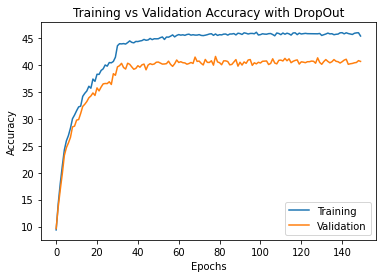

In [0]:
from matplotlib import pyplot as plt

plt.title("Training vs Validation Accuracy with DropOut")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(len(chart1_train)), chart1_train, label="Training")
plt.plot(range(len(chart1_val)), chart1_val, label="Validation")
plt.legend();

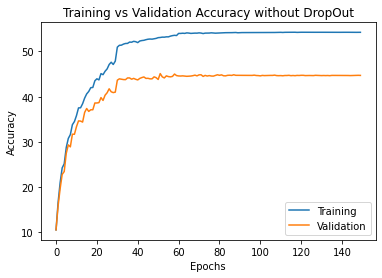

In [0]:
plt.title("Training vs Validation Accuracy without DropOut")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(len(chart2_train)), chart2_train, label="Training")
plt.plot(range(len(chart2_val)), chart2_val, label="Validation")
plt.legend();

In [0]:
chart2_train=copy.deepcopy(tr_acc)
chart2_val=copy.deepcopy(val_acc)
chart2_loss=copy.deepcopy(loss_dat)

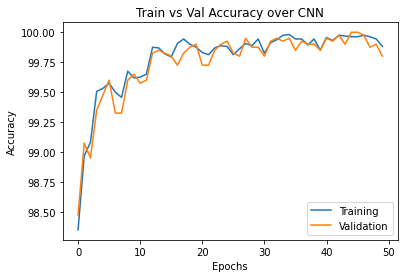

In [0]:
plt.title("Train vs Val Accuracy over CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(len(tr_acc)), tr_acc, label="Training")
plt.plot(range(len(val_acc)), val_acc, label="Validation")
plt.legend();

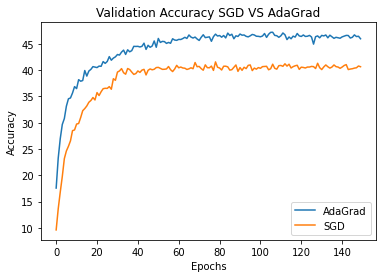

In [0]:
plt.title("Validation Accuracy SGD VS AdaGrad")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(len(val_acc)), val_acc, label="AdaGrad")
plt.plot(range(len(chart1_val)), chart1_val, label="SGD")
plt.legend();

No handles with labels found to put in legend.


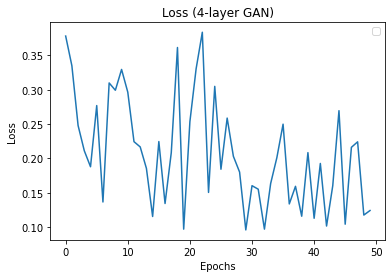

In [0]:
plt.title("Loss (4-layer GAN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(loss_dat)), loss_dat,)
plt.legend();

NameError: ignored

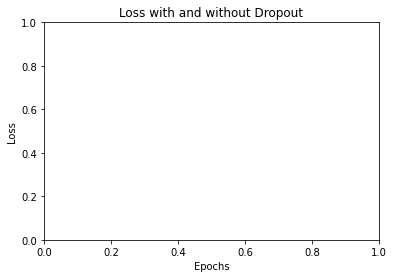

In [0]:
plt.title("Loss with and without Dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(chart2_loss)), chart2_loss, label="Without Dropout")
plt.plot(range(len(chart1_loss)), chart1_loss, label="With Dropout")
plt.legend();

In [0]:
import matplotlib.pyplot as plt


In [0]:
tr_acc

[1.5,
 2.902222222222222,
 4.337777777777778,
 5.66,
 6.695555555555556,
 8.22888888888889,
 10.124444444444444,
 11.586666666666666,
 12.595555555555556,
 15.397777777777778,
 16.313333333333333,
 17.15111111111111,
 19.413333333333334,
 20.584444444444443,
 22.88222222222222,
 23.973333333333333,
 25.166666666666668,
 26.56888888888889,
 27.366666666666667,
 28.633333333333333,
 27.997777777777777,
 28.602222222222224,
 30.342222222222222,
 31.391111111111112,
 32.75555555555555,
 32.626666666666665,
 33.44888888888889,
 34.07333333333333,
 33.54,
 34.88,
 35.92444444444445,
 35.24888888888889,
 37.28666666666667,
 37.58,
 36.96888888888889,
 38.34888888888889,
 38.797777777777775,
 39.25555555555555,
 39.87555555555556,
 39.73777777777778,
 40.184444444444445,
 39.75555555555555,
 40.74444444444445,
 41.16,
 41.028888888888886,
 41.53111111111111,
 42.611111111111114,
 42.73111111111111,
 42.52444444444444,
 41.55555555555556,
 43.617777777777775,
 43.593333333333334,
 44.12,
 44.1,

In [0]:
val_acc

[1.3,
 2.36,
 4.14,
 5.38,
 6.9,
 7.4,
 10.08,
 10.62,
 12.26,
 14.4,
 15.34,
 15.84,
 18.12,
 19.22,
 21.72,
 21.92,
 22.92,
 24.24,
 25.52,
 26.2,
 26.0,
 26.66,
 27.54,
 28.94,
 29.76,
 28.96,
 29.82,
 29.94,
 30.2,
 31.12,
 31.78,
 30.62,
 33.74,
 33.08,
 32.94,
 33.8,
 33.84,
 33.82,
 34.92,
 35.16,
 34.72,
 34.3,
 35.06,
 35.2,
 35.72,
 35.96,
 35.68,
 36.3,
 37.28,
 35.74,
 36.24,
 36.86,
 37.34,
 37.16,
 38.54,
 38.06,
 37.26,
 38.02,
 38.36,
 38.96,
 38.38,
 39.02,
 38.64,
 38.72,
 38.8,
 39.72,
 39.18,
 39.6,
 39.7,
 39.22,
 40.5,
 39.64,
 39.88,
 40.06,
 39.6,
 39.3,
 40.28,
 41.02,
 40.82,
 39.9,
 41.28,
 40.62,
 40.82,
 40.62,
 40.82,
 40.7,
 40.98,
 41.1,
 40.94,
 40.62,
 40.2,
 40.78,
 40.32,
 39.68,
 41.0,
 41.38,
 40.48,
 41.28,
 41.88,
 42.72,
 42.1,
 41.44,
 41.68,
 41.86,
 41.68,
 41.1,
 41.96,
 41.88,
 42.58,
 41.96,
 41.56,
 42.14,
 41.6,
 41.86,
 42.34,
 41.88,
 41.58,
 41.7,
 41.64,
 42.08,
 43.04,
 42.78,
 42.44,
 42.12,
 42.66,
 42.72,
 43.18,
 43.12,
 43.08,


In [0]:
loss_dat

[4.501336574554443,
 4.371716499328613,
 4.191889762878418,
 4.566026210784912,
 4.1361894607543945,
 3.6027121543884277,
 4.27572774887085,
 3.964383840560913,
 3.5030405521392822,
 3.5453219413757324,
 3.046281099319458,
 3.0694515705108643,
 3.409156560897827,
 3.5260627269744873,
 3.103425979614258,
 2.853008508682251,
 2.999816656112671,
 2.687835454940796,
 2.661215305328369,
 2.2202439308166504,
 3.0992815494537354,
 2.587942600250244,
 2.7122433185577393,
 2.7290356159210205,
 2.769998073577881,
 3.0720627307891846,
 2.854548692703247,
 2.5310378074645996,
 3.0982062816619873,
 2.4209988117218018,
 2.4439451694488525,
 2.516791820526123,
 1.9304068088531494,
 2.618420362472534,
 2.2178258895874023,
 2.5460634231567383,
 2.612114667892456,
 2.3564908504486084,
 2.0427334308624268,
 2.205382823944092,
 1.8754966259002686,
 2.1649515628814697,
 2.1472129821777344,
 2.4615139961242676,
 1.9142580032348633,
 2.11381459236145,
 2.1433560848236084,
 2.1943352222442627,
 2.694774389266

In [0]:
0 Total loss:0.689104, ID loss:0.854504,  Discriminator loss:0.091821
1 Total loss:0.830196, ID loss:0.660689,  Discriminator loss:0.003011
2 Total loss:0.833713, ID loss:0.596598,  Discriminator loss:0.002543
3 Total loss:0.830025, ID loss:0.637127,  Discriminator loss:0.002397
4 Total loss:0.790544, ID loss:0.501479,  Discriminator loss:0.001295
5 Total loss:0.768568, ID loss:0.478745,  Discriminator loss:0.000681
6 Total loss:0.749506, ID loss:0.439256,  Discriminator loss:0.000600
7 Total loss:0.770575, ID loss:0.453002,  Discriminator loss:0.000563
8 Total loss:0.756730, ID loss:0.505317,  Discriminator loss:0.001054
9 Total loss:0.719940, ID loss:0.409590,  Discriminator loss:0.000511
10 Total loss:0.761691, ID loss:0.431285,  Discriminator loss:0.000347
11 Total loss:0.751396, ID loss:0.419405,  Discriminator loss:0.000327
12 Total loss:0.753798, ID loss:0.421663,  Discriminator loss:0.002474
13 Total loss:0.734795, ID loss:0.424565,  Discriminator loss:0.001831
14 Total loss:0.725902, ID loss:0.375348,  Discriminator loss:0.000154
15 Total loss:0.712545, ID loss:0.389822,  Discriminator loss:0.000940
16 Total loss:0.713049, ID loss:0.369290,  Discriminator loss:0.000258
17 Total loss:0.754953, ID loss:0.409604,  Discriminator loss:0.000611
18 Total loss:0.723815, ID loss:0.387035,  Discriminator loss:0.001165
19 Total loss:0.749282, ID loss:0.413056,  Discriminator loss:0.000361
20 Total loss:0.744107, ID loss:0.387962,  Discriminator loss:0.000530
21 Total loss:0.713329, ID loss:0.353072,  Discriminator loss:0.000173
22 Total loss:0.754588, ID loss:0.416378,  Discriminator loss:0.000244
23 Total loss:0.725625, ID loss:0.376969,  Discriminator loss:0.000196
24 Total loss:0.721068, ID loss:0.365049,  Discriminator loss:0.000190

In [0]:
loss=[0.854504, 0.660689, 0.596598, 0.637127, 0.501479, 0.478745, 0.439256, 0.453002, 0.505317, 0.409590, 0.431285, 0.419405, 0.421663, 0.424565, 0.375348, 0.389822, 0.369290, 0.409604, 0.387035, 0.413056, 0.387962, 0.353072, 0.416378, 0.376969, 0.365049]

In [0]:
loss1=[0.091821, 0.003011, 0.002543, 0.002397, 0.001295, 0.000681, 0.000600, 0.000563, 0.001054, 0.000511, 0.000347, 0.000327, 0.002474, 0.001831, 0.000154, 0.000940, 0.000258, 0.000611, 0.001165, 0.000361, 0.000530, 0.000173, 0.000244, 0.000196, 0.000190]

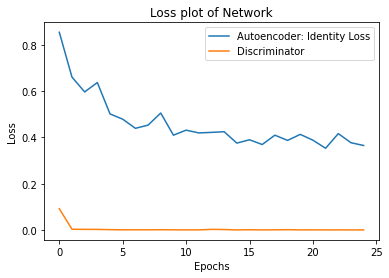

In [0]:
plt.title("Loss plot of Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(loss)), loss, label='Autoencoder: Identity Loss');
plt.plot(range(len(loss1)), loss1, label='Discriminator');
plt.legend();

In [0]:
import matplotlib.pyplot as plt
